In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import subprocess

In [71]:
def run_process(name, no_iters=5, count=1_000_000, domains=16, validate=False, verbose=False, init_count=None, sorted=None):
    cmd = ["../_build/default/benchmarks/bench.exe", name, "-D", str(domains), "--no-iter", str(no_iters), "--count", str(count)]
    if validate:
        cmd += ["-T"]
    if init_count:
        cmd += ["--init-count", str(init_count)]
    if sorted:
        cmd += ["-s"]
    result = subprocess.run(cmd, capture_output=True)
    stdout = result.stdout.decode("utf-8").splitlines()
    for output in stdout[:-1]:
        print(output)
    [time, _, var] = stdout[-1].split()
    time = time.removesuffix("s").strip()
    var = var.removesuffix("s").strip()
    if verbose:
        print(f"time for {name} with {count} inserts was {time} +- {var}")
    return float(time), float(var)

In [70]:
t = "hello world\nbad".splitlines()
t[:-1], t[-1]

(['hello world'], 'bad')

In [4]:
run_process("btree-explicitly", count=100)

time for btree-explicitly with 100 inserts was 0.00003 +- 0.00000


(3e-05, 0.0)

In [116]:
def build_results(data_structures, args, param='domains', values=None):
    results = []
    if not values:
        values = range(1, 16)
    for i in tqdm(values):
        result = {param: i}
        for data_structure in data_structures:
            time, sd = run_process(data_structure, **{param:i}, **args)
            result[data_structure] = time
            result[data_structure + "-var"] = sd
        results.append(result)
    return results

results = build_results(["btree-batched", "btree-coarse", "btree-sequential"], {'count': 1_000_000 })

  0%|          | 0/15 [00:00<?, ?it/s]

time for btree-batched with 1000000 inserts was 3.05413 +- 0.19345
time for btree-coarse with 1000000 inserts was 2.75316 +- 0.03810
time for btree-sequential with 1000000 inserts was 2.26103 +- 0.01314
time for btree-batched with 1000000 inserts was 2.43709 +- 0.07172
time for btree-coarse with 1000000 inserts was 3.30700 +- 0.03822
time for btree-sequential with 1000000 inserts was 2.35889 +- 0.03645
time for btree-batched with 1000000 inserts was 2.00035 +- 0.06058
time for btree-coarse with 1000000 inserts was 4.06262 +- 0.24462
time for btree-sequential with 1000000 inserts was 2.33674 +- 0.05125
time for btree-batched with 1000000 inserts was 1.90394 +- 0.11824
time for btree-coarse with 1000000 inserts was 3.99452 +- 0.17592
time for btree-sequential with 1000000 inserts was 2.32384 +- 0.01729
time for btree-batched with 1000000 inserts was 1.81973 +- 0.10382
time for btree-coarse with 1000000 inserts was 4.14020 +- 0.14754
time for btree-sequential with 1000000 inserts was 2.31

In [114]:
def plot_results(param, data_structures, results, title=None, xlabel=None):
    if not title:
        title = f"Comparison of {param} values on data structure"
    if not xlabel:
        xlabel=param
    param_values = [data[param] for data in results]
    fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
    for data_structure in data_structures:
        values = [data[data_structure] for data in results]
        err = [data[data_structure + "-var"] for data in results]
        plt.errorbar(param_values, values, yerr=err, label=data_structure)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Time (s)')
    plt.legend()
    plt.show()    

In [27]:
plot_results('domains', ["btree-batched", "btree-coarse", "btree-sequential"], results)

NameError: name 'plot_results' is not defined

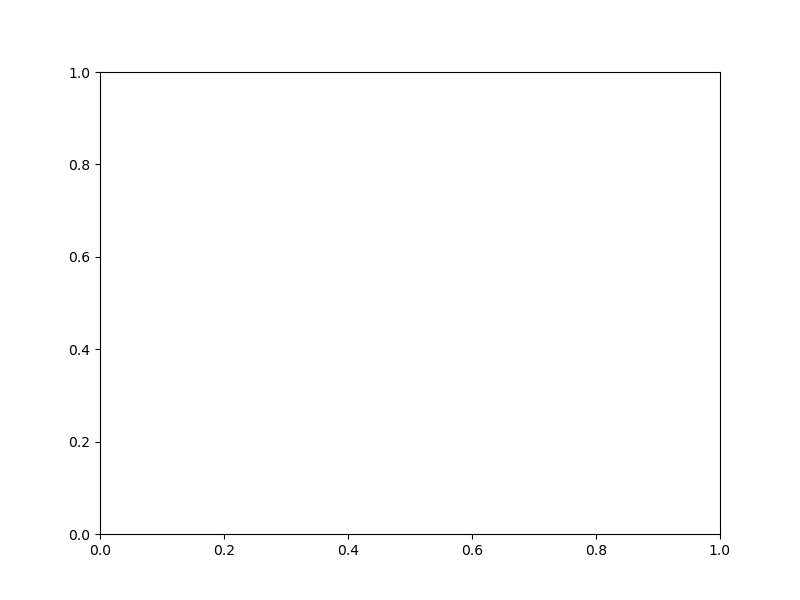

In [64]:
%matplotlib widget
import time
fig = plt.figure(figsize=(8,6), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
plt.ion()

In [78]:
data_structures=['btree-sequential', 'btree-explicit']
params={'count': 100_000, 'init_count': 100_000, 'validate': True }
times=[]
results=[]


for i in range(1, 16):
    result={'domains': i}
    times.append(i)
    results.append(result)
    for data_structure in data_structures:
        t,var = run_process(data_structure,**params)
        result[data_structure]=t
        result[data_structure+'-var']=var
        
        ax.clear()
        ax.set_title("Comparison of Sequential vs. our parallel insert")
        ax.set_xlabel('No. Domains')
        ax.set_ylabel('Time (s)')
        for data_structure in data_structures:
            available_values=[data[data_structure] for data in results if data_structure in data]
            available_var=[data[data_structure+'-var'] for data in results if (data_structure+'-var') in data]
            available_times=times[:len(available_values)]
            ax.errorbar(available_times, available_values, yerr=available_var, label=data_structure)
        ax.legend()
        fig.canvas.draw()

In [42]:
results

[]

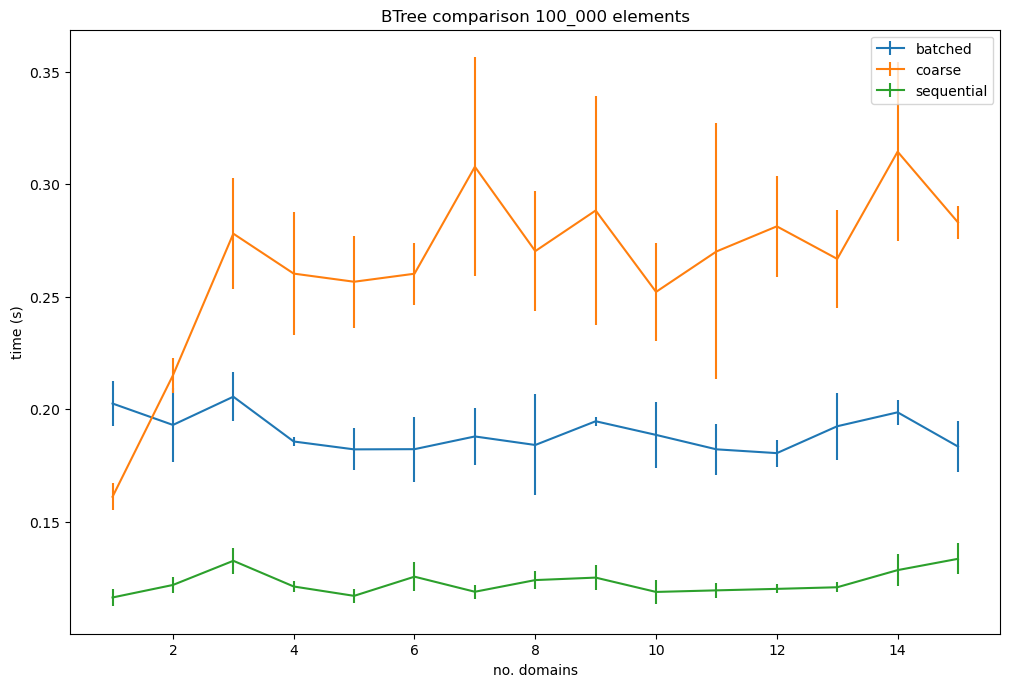

In [90]:
fig = plt.figure(figsize=(12,8), dpi=100, facecolor='w', edgecolor='k')
plt.errorbar(times, batched, yerr=[data['batched_var'] for data in results], label="batched")
plt.errorbar(times, coarse, yerr=[data['coarse_var'] for data in results], label="coarse")
plt.errorbar(times, sequential, yerr=[data['sequential_var'] for data in results], label="sequential")
plt.title('BTree comparison 100_000 elements')
plt.xlabel('no. domains')
plt.ylabel('time (s)')
plt.legend()
plt.show()

In [85]:
results

[{'domains': 1,
  'batched': 0.20259,
  'batched_var': 0.01006,
  'coarse': 0.16116,
  'coarse_var': 0.00594,
  'sequential': 0.11638,
  'sequential_var': 0.00391},
 {'domains': 2,
  'batched': 0.19307,
  'batched_var': 0.01639,
  'coarse': 0.21511,
  'coarse_var': 0.0077,
  'sequential': 0.12194,
  'sequential_var': 0.00347},
 {'domains': 3,
  'batched': 0.20562,
  'batched_var': 0.0109,
  'coarse': 0.27809,
  'coarse_var': 0.02461,
  'sequential': 0.13268,
  'sequential_var': 0.00572},
 {'domains': 4,
  'batched': 0.18571,
  'batched_var': 0.00213,
  'coarse': 0.26034,
  'coarse_var': 0.02716,
  'sequential': 0.12126,
  'sequential_var': 0.00251},
 {'domains': 5,
  'batched': 0.18221,
  'batched_var': 0.00936,
  'coarse': 0.25672,
  'coarse_var': 0.02037,
  'sequential': 0.1171,
  'sequential_var': 0.00319},
 {'domains': 6,
  'batched': 0.1823,
  'batched_var': 0.01443,
  'coarse': 0.26029,
  'coarse_var': 0.01385,
  'sequential': 0.12562,
  'sequential_var': 0.00647},
 {'domains': 7